# Importing necessary Libraries

In [45]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from tensorflow.keras.applications import MobileNet
from google.colab import files
from tensorflow.keras.preprocessing import image

# Loading Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Visualizing Dataset

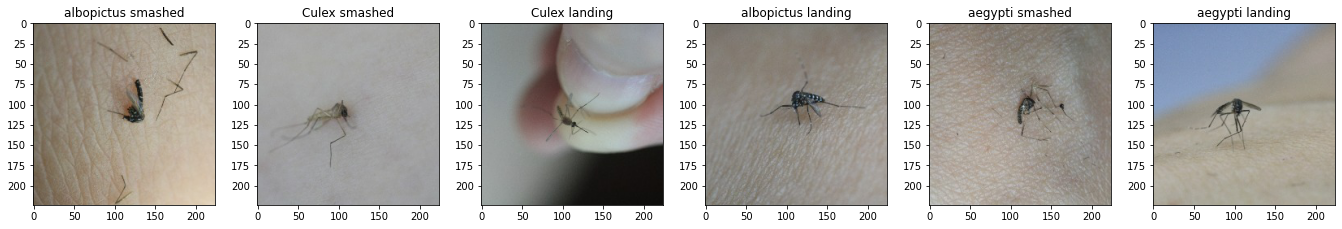

In [27]:
""" Displaying an image from each class of the Training Dataset """
num_class = 6

# Setting the size of the figure
fig = plt.gcf()
fig.set_size_inches(200,200)

# Completing Training path
train_path = os.path.join(path,'Train')

# Names of each class
class_name = os.listdir(train_path)

# Loop to Display Image from each class
for index, name in enumerate(class_name):
  # Path for the class 
  class_path = os.path.join(train_path,name)

  # Forming Image Path
  image_path = os.listdir(class_path)[0]
  image = os.path.join(class_path, image_path)

  # Loading Image
  img = plt.imread(image)

  # Displaying Image
  plt.subplot(50,50,index+1)
  plt.imshow(img)
  plt.title(name)

**Using Image Data Generator to load data**

In [3]:
# Creating a Data Generator while loading the dataset from the individual 
# directories (with Data Augmentation)
data_gen = ImageDataGenerator(
                rescale = 1./255,
                horizontal_flip = True,
                shear_range = 0.3,
                zoom_range = 0.3,
                width_shift_range = 0.3,
                height_shift_range = 0.3,
                fill_mode = 'nearest'
) 

In [8]:
"""Path to the Google Directory for the folder"""
path = '/content/drive/MyDrive/Mosquito Dataset/data_splitting'

#Training Data Generator
train_path = os.path.join(path, "Train")
train_datagen = data_gen.flow_from_directory(
                train_path,
                batch_size = 64,
                class_mode = 'categorical',
                target_size = (224,224)
)

# Validation Data Generator
valid_path = os.path.join(path, "Pred")
valid_datagen  = data_gen.flow_from_directory(
                 valid_path,
                 batch_size = 64,
                 class_mode = 'categorical',
                 target_size = (224,224)
)

# Testing Data Generator
test_path = os.path.join(path, "Test")
test_datagen = data_gen.flow_from_directory(
               test_path,
               class_mode = 'categorical',
               target_size = (224,224),
               batch_size = 64
)

Found 4200 images belonging to 6 classes.
Found 3600 images belonging to 6 classes.
Found 1799 images belonging to 6 classes.


**CallBack to reduce the learning rate if the VALIDATION LOSS do not decrease for a certain number of epochs**

In [28]:
myCallback = callbacks.ReduceLROnPlateau(
             monitor = 'val_loss',
             patience = 2,
             factor = 0.02,
             lr = 1e-30
)

# Configuring MobileNet for Transfer Learning

In [29]:
pre_trained_model = MobileNet(
                    include_top = False,
                    input_shape = (224,224,3),
                    weights = 'imagenet',
                    classes = 6
)

# Freezing the layers of the Pre-trained model
for layer in pre_trained_model.layers:
  layer.trainable = False

17235968/17225924 [==============================] - 0s 0us/step


In [31]:
pre_trained_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

# Defining Model Architecture

In [32]:
model = Sequential()

# Adding Pre-Tained Model to the network
model.add(pre_trained_model)

# Adding layers to the network
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))

# Output Layer in the model
model.add(Dense(6, activation = 'softmax'))

# Compiling the model
model.compile(loss = 'categorical_crossentropy', metrics = ['accuracy'],
              optimizer = Adam(learning_rate = 0.001))

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 128)               6422656   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 6)                 198       
                                                        

In [35]:
# Training Model
history = model.fit(
          train_datagen,
          epochs = 40,
          validation_data = valid_datagen,
          callbacks = [myCallback],
          verbose = 2
)

Epoch 1/40
66/66 - 2490s - loss: 1.8985 - accuracy: 0.4088 - val_loss: 1.1676 - val_accuracy: 0.5528 - lr: 0.0010 - 2490s/epoch - 38s/step
Epoch 2/40
66/66 - 383s - loss: 0.9432 - accuracy: 0.6312 - val_loss: 0.9953 - val_accuracy: 0.6089 - lr: 0.0010 - 383s/epoch - 6s/step
Epoch 3/40
66/66 - 340s - loss: 0.7986 - accuracy: 0.6895 - val_loss: 0.7648 - val_accuracy: 0.7014 - lr: 0.0010 - 340s/epoch - 5s/step
Epoch 4/40
66/66 - 347s - loss: 0.6783 - accuracy: 0.7452 - val_loss: 0.6251 - val_accuracy: 0.7547 - lr: 0.0010 - 347s/epoch - 5s/step
Epoch 5/40
66/66 - 345s - loss: 0.6517 - accuracy: 0.7488 - val_loss: 0.6564 - val_accuracy: 0.7456 - lr: 0.0010 - 345s/epoch - 5s/step
Epoch 6/40
66/66 - 347s - loss: 0.5898 - accuracy: 0.7719 - val_loss: 0.5837 - val_accuracy: 0.7769 - lr: 0.0010 - 347s/epoch - 5s/step
Epoch 7/40
66/66 - 345s - loss: 0.5381 - accuracy: 0.7957 - val_loss: 0.5996 - val_accuracy: 0.7858 - lr: 0.0010 - 345s/epoch - 5s/step
Epoch 8/40
66/66 - 384s - loss: 0.5301 - accu

**Saving model in the memory**

In [37]:
model.save("Mosquito_Transfer_Learning.h5")

# Plotting Training and Validation Graphs (Accuracy and Loss separately)

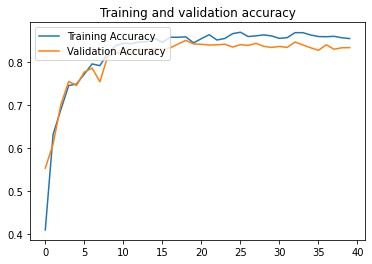

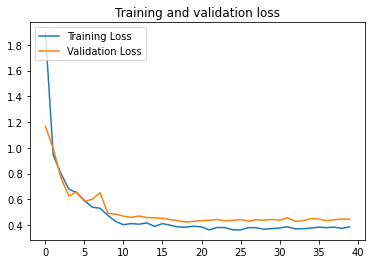

In [40]:
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.legend(['Training Accuracy','Validation Accuracy'], loc = 'upper left')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )
plt.legend(['Training Loss','Validation Loss'], loc = 'upper left')
plt.show()

# Predcition on Test Data

In [41]:
predictions = model.evaluate(test_datagen)

29/29 [==============================] - 665s 24s/step - loss: 0.5124 - accuracy: 0.7871


# Testing on Individual Image (This one was shared by Lawrence in his LinkedIn post)

Saving 1658895613398.jfif to 1658895613398 (3).jfif


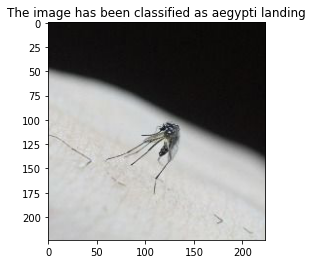

In [49]:
# Prompting to Upload
uploaded = files.upload()

# Defining all the class names for classify them as one
classes_names = ['albopictus smashed', 'Culex smashed', 'Culex landing', 'albopictus landing', 'aegypti smashed', 'aegypti landing']

# Predicting the image using the model trained above
for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(224, 224,3))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  
  # Maximum Probability WINS
  max_index = np.argmax(classes[0])

  # Displaying Image
  plt.figure()
  plt.imshow(img)
  plt.title(f"The image has been classified as {class_name[max_index]}")